# Final Project Submission
---

## Info

* Student name: **Barto Molina**
* Student pace: **part time**
* Scheduled project review date/time: **TODO**
* Instructor name: **Victor Geislinger**
* Blog post URL: **TODO**

## The Project

Given the data included in the Northwind database, we'll perform a statistical analysis in order to perform hypothesis tests to answer the questions below.

**1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?**  
**2. Does the unit price have a statistically significant effect on the quantity of a product in an order?**  
**3.**

This is the schema of the Northwind database:

![Northwind DB Schema](Northwind_ERD_updated.png "Northwind DB Schema")

## Imports

We'll import the required libraries that will be used throughout the rest of the project:

In [99]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

## 1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

First, we're going to define our hypthesis:

- **$H_{0}$ - Null Hypothesis:** Discount has no statistically significant effect on the quantity of a product in an order
- **$H_{1}$ - Alternative hypothesis:** Discount has a statistically significant effect on the quantity of a product in an order

We're going to consider a standard $\alpha$ of 0.05

Let's load the information from the order details into a dataframe

In [100]:
conn = sqlite3.connect("Northwind_small.sqlite")
cur = conn.cursor()

df_orders = pd.read_sql_query("""SELECT CAST (Discount * 100 AS INT) AS Discount, SUM(Quantity) AS Quantity
                       FROM OrderDetail GROUP BY Discount""", conn)

cur.close()
conn.close()

df_orders

,Discount,Quantity
0,0,28599
1,1,2
2,2,4
3,3,5
4,4,1
5,5,5182
6,6,2
7,10,4366
8,15,4456
9,20,4351


We can see that the main discount categories are **0%**, **5%**, **10%**, **15%**, **20%** and **25%**. We'll ignore the rest of the discount categories:

In [101]:
conn = sqlite3.connect("Northwind_small.sqlite")
cur = conn.cursor()

df_orders = pd.read_sql_query("""SELECT CAST (Discount * 100 AS INT) AS Discount, Quantity AS Quantity
                       FROM OrderDetail GROUP BY OrderID, ProductId HAVING Discount IN (0, 0.05, 0.10, 0.15, 0.20, 0.25)""", conn)

cur.close()
conn.close()

df_orders.head()

,Discount,Quantity
0,0,12
1,0,10
2,0,5
3,0,9
4,0,40


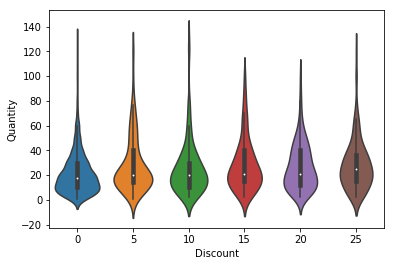

In [74]:
sns.violinplot(x=df_orders['Discount'],y=df_orders['Quantity'])
plt.show()

### Welch's T-test

In [92]:
df_nodiscount = df_orders[df_orders['Discount'] == 0].Quantity
df_discount = df_orders[df_orders['Discount'] != 0].Quantity

welchs = stats.ttest_ind(df_nodiscount, df_discount, equal_var=False)
welchs.pvalue

1.0051255540843165e-10

The result is a very small p-value, much smaller than our $\alpha$ value, meaning that the Null Hypothesis can be rejected. However, we still need to calculate the effect size:

### Effect size / Cohen's d

In [77]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [78]:
Cohen_d(df_discount, df_nodiscount)

0.2997078720940889

As the effect (**0.3**) is higher than **0.2** we can consider it has a reasonably positive effect

### Compare different discounts levels

In [97]:
for discount in (5, 10, 15, 20, 25):
    df_nodiscount = df_orders[df_orders['Discount'] == 0].Quantity
    df_discount = df_orders[df_orders['Discount'] == discount].Quantity

    welchs = stats.ttest_ind(df_nodiscount, df_discount, equal_var=False)
    print(f"p-value for {discount}% discount = {welchs.pvalue}")

p-value for 5% discount = 0.00027233494432847593
p-value for 10% discount = 0.0374559661063408
p-value for 15% discount = 0.00017220729443627393
p-value for 20% discount = 0.0008110033254043408
p-value for 25% discount = 0.00015923050922125637


**We can see that the 25% discount has the highest effect on the quantity ordered**

### ANOVA

In [ ]:
formula = 'S ~ C(E) + C(M) + X'
lm = ols(formula, df_orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)